# Deep Neural Network(DNN) for data fitting
### Shuhe Wang, Dec 2019

## Import packages and functions

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.framework.python.framework import checkpoint_utils as cu
from random import shuffle
import numpy as np
import os

/Users/shuhe.wang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shuhe.wang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shuhe.wang/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shuhe.wang/anaconda3/lib/python3.6/site-packages/tensorflow/

Instructions for updating:
Use the retry module or similar alternatives.


## Customize global parameters

In [2]:
# Customize global parameters here.
num_examples = 5000
validation_fraction = 0.1
test_fraction = 0.1
training_epochs = 1000
PLOT_FIGURE = True
figure_size = (8, 4.5)
marker_size = 5.0
neuron_of_layer = [1, 50, 50, 50, 50, 50, 50, 50, 1]

# The parameters below are automatically generated
# !!! DO NOT CHANGE !!!
validation_set_size = int(num_examples*validation_fraction)
test_set_size = int(num_examples*test_fraction)
training_set_size = num_examples - validation_set_size - test_set_size
training_epochs_digits = len(list(str(training_epochs)))
display_step = int(training_epochs*0.1)
num_of_all_layers = len(neuron_of_layer)
num_of_hidden_layers = num_of_all_layers - 2

assert type(num_examples)==int and num_examples>0
assert training_set_size>0
assert type(training_epochs)==int and training_epochs>10
for i in neuron_of_layer:
	assert type(i)==int and i>0

## Generate data sets

In [3]:
def f(x: np.array) -> np.array:
    """
        DEFINE YOUR PREFERRED FUNCTIONS HERE (e.g. return np.cos(x))
    """
    pass

In [36]:
all_x = np.random.uniform(0*np.pi, np.pi, (1, num_examples)).T
np.random.shuffle(all_x)

x_training, x_validation, x_test = (all_x[:training_set_size], 
                                    all_x[training_set_size: training_set_size + validation_set_size],
                                    all_x[training_set_size + validation_set_size:])

(y_training, y_validation, y_test) = (f(x) for x in (x_training, x_validation, x_test))


In [35]:
try:
    os.mkdir("./figure")
except:
    pass

figure_path = os.getcwd() + '/figure'

In [38]:
tf.reset_default_graph()

(X, Y) = (tf.placeholder(tf.float32, [None, neuron_of_layer[0]], name='Input'),
          tf.placeholder(tf.float32, [None, neuron_of_layer[-1]], name='Output'))
(weights, biases) = ({str(i): tf.Variable(tf.random_normal([neuron_of_layer[i], neuron_of_layer[i+1]]),
                          name = 'w{:d}'.format(i)) for i in range(num_of_all_layers-1)},
                     {str(i): tf.Variable(tf.zeros([neuron_of_layer[i+1]]), name = 'b{:d}'.format(i))
                          for i in range(num_of_all_layers-1)})

In [7]:
def DNN(input_data, num_of_hidden_layers):
    def _build_hidden(num_of_hidden_layers):
        current_layer = 0
        output_current_layer = input_data[:]
        while current_layer < num_of_hidden_layers:
            Z = tf.add(
                    tf.matmul(output_current_layer, weights['%d'%(current_layer)]),
                    biases['%d'%(current_layer)]
                )
            output_current_layer = tf.nn.sigmoid(Z, name='layer%d'%(current_layer))
            current_layer += 1
        return str(current_layer), output_current_layer 

    next_layer, layer = _build_hidden(num_of_hidden_layers)  
    output_NN = tf.add(tf.matmul(layer, weights[next_layer]), biases[next_layer])
    return output_NN

In [8]:
output = DNN(X, num_of_hidden_layers)
cost = tf.reduce_mean(tf.square(output - Y))
optimizer = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(output - Y))

In [10]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

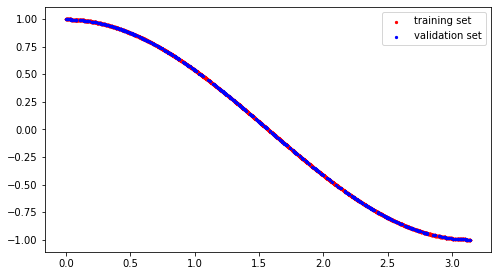

In [11]:
if PLOT_FIGURE:
    fig = plt.figure(figsize=figure_size)
    plt.scatter(x_training, y_training, c='r', label='training set', s=marker_size)
    plt.scatter(x_validation, y_validation, c='b', label='validation set', s=marker_size)
    plt.legend()
    fig.savefig(os.path.join(figure_path, 'training_and_validation_sets.jpg'))

## Train the DNN

In [25]:
for epoch in range(1, training_epochs+1):
    _, c = sess.run(
        [optimizer, cost ],
        feed_dict={X: x_training, Y: y_training}
    )

    mse = sess.run(tf.nn.l2_loss(output - y_validation), feed_dict={X: x_validation})
    
    if not epoch % display_step :
        print('Epoch: %0*d\tCost : %.6f'%(training_epochs_digits, epoch, c))
        if PLOT_FIGURE:
            fig = plt.figure(figsize=figure_size)
            plt.scatter(x_validation, y_validation, color='b', label='validation set', s=marker_size)
            plt.scatter(x_validation, sess.run(output, feed_dict={X: x_validation}),
                        color='r', label='DNN prediction', s=marker_size) 
            plt.legend()         
            fig.savefig(os.path.join(figure_path, '%*d_DNN_prediction.jpg'%(training_epochs_digits, epoch)))

print('Epoch: %03d\tMSE  : %.6f'%(epoch, c), 'Training complete!', sep='\n')

save_model_list = [weights[i] for i in weights] + [biases[i] for i in biases]
saver = tf.train.Saver(save_model_list)
saver.save(sess, './trained_model/trained_model.ckpt')

plt.close('all')
sess.close()


Epoch: 0100	Cost : 0.000045
Epoch: 0200	Cost : 0.000043
Epoch: 0300	Cost : 0.000042
Epoch: 0400	Cost : 0.000041
Epoch: 0500	Cost : 0.000041
Epoch: 0600	Cost : 0.000055
Epoch: 0700	Cost : 0.000044
Epoch: 0800	Cost : 0.000036
Epoch: 0900	Cost : 0.000036
Epoch: 1000	Cost : 0.000034
Epoch: 1000	MSE  : 0.000034
Training complete!


## Run your trained DNN now

In [26]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def _DNN(input_data, num_of_hidden_layers):
    def _build_hidden(num_of_hidden_layers):
        current_layer = 0
        output_current_layer = input_data[:]
        while current_layer < num_of_hidden_layers:
            Z = np.add(
                    np.matmul(output_current_layer, _weights['%d'%(current_layer)]),
                    _biases['%d'%(current_layer)]
                )
            output_current_layer = sigmoid(Z)
            current_layer += 1
        return str(current_layer), output_current_layer 
        
    next_layer, layer = _build_hidden(num_of_hidden_layers)  
    output_NN = np.add(np.matmul(layer, _weights[next_layer]), _biases[next_layer])
    return output_NN

In [37]:
_ckpt_reader = tf.train.load_checkpoint('./trained_model/')
for model_element in cu.list_variables('./trained_model/'):
    print(model_element)

('b0', [50])
('b1', [50])
('b2', [50])
('b3', [50])
('b4', [50])
('b5', [50])
('b6', [50])
('b7', [1])
('w0', [1, 50])
('w1', [50, 50])
('w2', [50, 50])
('w3', [50, 50])
('w4', [50, 50])
('w5', [50, 50])
('w6', [50, 50])
('w7', [50, 1])


In [28]:
(_weights, _biases) = ({str(i): _ckpt_reader.get_tensor('w{:d}'.format(i)) for i in range(8)}, 
                       {str(i): _ckpt_reader.get_tensor('b{:d}'.format(i)) for i in range(8)})

_output = _DNN(x_test, num_of_hidden_layers)

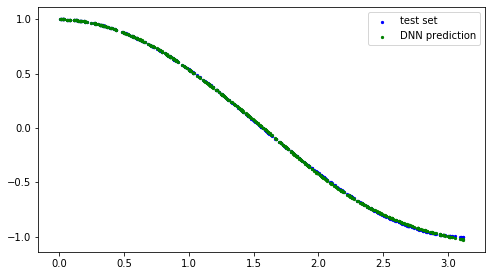

In [29]:
_fig = plt.figure(figsize = figure_size)
plt.scatter(x_test, y_test, color='b', label='test set', s=marker_size)
plt.scatter(x_test, _output, color='g', label='DNN prediction', s=marker_size)
plt.legend()
plt.show()